# Week 1 - Pythagorean Expectation on NBA data (2018 season)

In [27]:
# %load ./imports.py
# %load /Users/bartev/dev/github-bv/sporty/notebooks/imports.py

## Where am I
!echo $VIRTUAL_ENV

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# magics
%load_ext blackcellmagic
# start cell with `%%black` to format using `black`

%load_ext autoreload
# start cell with `%autoreload` to reload module
# https://ipython.org/ipython-doc/stable/config/extensions/autoreload.html

# reload all modules when running
%autoreload 2

# imports

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns

from importlib import reload
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# https://plotnine.readthedocs.io/en/stable/

import plotnine as p9
from plotnine import ggplot, aes, facet_wrap

from src.utils import lower_case_col_names

/Users/bartev/.venvs/sport


The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read data

Download data from Kaggle

https://www.kaggle.com/nathanlauga/nba-games/activity

In [5]:
data_dir = Path('../data/raw/wk1-nba/nba-kaggle')
[f for f in data_dir.iterdir()]

[PosixPath('../data/raw/wk1-nba/nba-kaggle/teams.csv'),
 PosixPath('../data/raw/wk1-nba/nba-kaggle/players.csv'),
 PosixPath('../data/raw/wk1-nba/nba-kaggle/games.csv'),
 PosixPath('../data/raw/wk1-nba/nba-kaggle/ranking.csv'),
 PosixPath('../data/raw/wk1-nba/nba-kaggle/games_details.csv')]

In [28]:
game_details = pd.read_csv(data_dir / 'games_details.csv').pipe(lower_case_col_names)
games = pd.read_csv(data_dir / 'games.csv').pipe(lower_case_col_names)
teams = pd.read_csv(data_dir / 'teams.csv').pipe(lower_case_col_names)
players = pd.read_csv(data_dir / 'players.csv').pipe(lower_case_col_names)
rankings = pd.read_csv(data_dir / 'ranking.csv').pipe(lower_case_col_names)

In [85]:
teams.head()

,league_id,team_id,min_year,max_year,abbreviation,nickname,yearfounded,city,arena,arenacapacity,owner,generalmanager,headcoach,dleagueaffiliation
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,"18,729.000",Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,"18,624.000",Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,"21,711.000",Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,"19,200.000",Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends


In [29]:
print(games.shape)
games.head()

(24677, 21)


,game_date_est,game_id,game_status_text,home_team_id,visitor_team_id,season,team_id_home,pts_home,fg_pct_home,ft_pct_home,fg3_pct_home,ast_home,reb_home,team_id_away,pts_away,fg_pct_away,ft_pct_away,fg3_pct_away,ast_away,reb_away,home_team_wins
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120.000,0.557,0.684,0.429,26.000,45.000,1610612764,95.000,0.402,0.633,0.091,22.000,40.000,1
1,2021-05-26,42000132,Final,1610612752,1610612737,2020,1610612752,101.000,0.383,0.739,0.364,15.000,54.000,1610612737,92.000,0.369,0.818,0.273,17.000,41.000,1
2,2021-05-26,42000142,Final,1610612762,1610612763,2020,1610612762,141.000,0.544,0.774,0.487,28.000,42.000,1610612763,129.000,0.541,0.763,0.348,20.000,33.000,1
3,2021-05-25,42000112,Final,1610612751,1610612738,2020,1610612751,130.000,0.523,0.955,0.447,31.000,46.000,1610612738,108.000,0.424,0.783,0.353,23.000,43.000,1
4,2021-05-25,42000152,Final,1610612756,1610612747,2020,1610612756,102.000,0.465,0.933,0.308,21.000,31.000,1610612747,109.000,0.450,0.871,0.303,24.000,39.000,0


In [31]:
games_18 = games.query("season == 2018")

print(games_18.shape)
games_18.head()

(1378, 21)


,game_date_est,game_id,game_status_text,home_team_id,visitor_team_id,season,team_id_home,pts_home,fg_pct_home,ft_pct_home,fg3_pct_home,ast_home,reb_home,team_id_away,pts_away,fg_pct_away,ft_pct_away,fg3_pct_away,ast_away,reb_away,home_team_wins
17678,2019-06-13,41800406,Final,1610612744,1610612761,2018,1610612744,110.000,0.488,0.700,0.355,28.000,42.000,1610612761,114.000,0.476,0.793,0.394,25.000,39.000,0
17679,2019-06-10,41800405,Final,1610612761,1610612744,2018,1610612761,105.000,0.447,0.778,0.250,19.000,43.000,1610612744,106.000,0.463,0.714,0.476,27.000,37.000,0
17680,2019-06-07,41800404,Final,1610612744,1610612761,2018,1610612744,92.000,0.449,0.667,0.296,26.000,42.000,1610612761,105.000,0.419,0.958,0.313,22.000,39.000,0
17681,2019-06-05,41800403,Final,1610612744,1610612761,2018,1610612744,109.000,0.396,0.833,0.333,25.000,41.000,1610612761,123.000,0.524,0.952,0.447,30.000,40.000,0
17682,2019-06-02,41800402,Final,1610612761,1610612744,2018,1610612761,104.000,0.372,0.885,0.289,17.000,49.000,1610612744,109.000,0.463,0.870,0.382,34.000,42.000,0


In [55]:
tmp = (
    games_18[
        [
            "game_date_est",
            "game_id",
            "home_team_id",
            "visitor_team_id",
            "pts_home",
            "pts_away",
            "home_team_wins",
        ]
    ]
    .rename(columns={"game_date_est": "date",})
    .assign(away_team_wins=lambda x: 1 - x['home_team_wins'])
    #  .merge(teams[['team_id', 'abbreviation', 'nickname', 'city']], left_on='home_team_id', right_on='team_id')
)

Check for missing rows

In [51]:
print(tmp.shape, f"missing data? {tmp.shape != tmp.dropna().shape}")


(1378, 8) missing data? False


In [56]:
tmp

,date,game_id,home_team_id,visitor_team_id,pts_home,pts_away,home_team_wins,away_team_wins
17678,2019-06-13,41800406,1610612744,1610612761,110.000,114.000,0,1
17679,2019-06-10,41800405,1610612761,1610612744,105.000,106.000,0,1
17680,2019-06-07,41800404,1610612744,1610612761,92.000,105.000,0,1
17681,2019-06-05,41800403,1610612744,1610612761,109.000,123.000,0,1
17682,2019-06-02,41800402,1610612761,1610612744,104.000,109.000,0,1
...,...,...,...,...,...,...,...,...
19051,2018-09-30,11800009,1610612741,1610612740,128.000,116.000,1,0
19052,2018-09-30,11800010,1610612747,1610612743,107.000,124.000,0,1
19053,2018-09-29,11800003,1610612761,1610612757,122.000,104.000,1,0
19054,2018-09-29,11800005,1610612744,1610612750,110.000,114.000,0,1


In [73]:
home_cols = ['date', 'game_id', 'home_team_id', 'pts_home', 'pts_away', 'home_team_wins', 'away_team_wins',]
away_cols = ['date', 'game_id', 'visitor_team_id', 'pts_away', 'pts_home', 'away_team_wins', 'home_team_wins', ]
home_tall = (tmp[home_cols]
  .rename(columns={'home_team_id': 'team_id', 
                  'home_team_wins': 'W',
                   'away_team_wins': 'L',
                  'pts_home': 'pts_scored',
                  'pts_away': 'pts_allowed'}))
away_tall = (tmp[away_cols]
  .rename(columns={'visitor_team_id': 'team_id', 
                  'away_team_wins': 'W',
                   'home_team_wins': 'L',
                  'pts_away': 'pts_scored',
                  'pts_home': 'pts_allowed'}))

In [74]:
home_tall.head()

,date,game_id,team_id,pts_scored,pts_allowed,W,L
17678,2019-06-13,41800406,1610612744,110.000,114.000,0,1
17679,2019-06-10,41800405,1610612761,105.000,106.000,0,1
17680,2019-06-07,41800404,1610612744,92.000,105.000,0,1
17681,2019-06-05,41800403,1610612744,109.000,123.000,0,1
17682,2019-06-02,41800402,1610612761,104.000,109.000,0,1


In [75]:
away_tall.head()

,date,game_id,team_id,pts_scored,pts_allowed,W,L
17678,2019-06-13,41800406,1610612761,114.000,110.000,1,0
17679,2019-06-10,41800405,1610612744,106.000,105.000,1,0
17680,2019-06-07,41800404,1610612761,105.000,92.000,1,0
17681,2019-06-05,41800403,1610612761,123.000,109.000,1,0
17682,2019-06-02,41800402,1610612744,109.000,104.000,1,0


In [93]:
team_id_names = teams.assign(name=lambda x: x["city"] + " " + x["nickname"])[
    ["team_id", "name"]
]
team_id_names.head()

,team_id,name
0,1610612737,Atlanta Hawks
1,1610612738,Boston Celtics
2,1610612740,New Orleans Pelicans
3,1610612741,Chicago Bulls
4,1610612742,Dallas Mavericks


Note: I didn't pull out playoff games. Normally, each team plays 82 games

In [95]:
pyth_ex_nba = (
    pd.concat([home_tall, away_tall])
    .merge(team_id_names, on='team_id')
    .groupby("name")["W", "L", "pts_scored", "pts_allowed"]
    .sum()
    .assign(
        wpc=lambda x: x["W"] / (x["W"] + x["L"]),
        pyth=lambda x: x["pts_scored"] ** 2
        / (x["pts_scored"] ** 2 + x["pts_allowed"] ** 2),
    )
)

pyth_ex_nba

/Users/bartev/.venvs/sport/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,W,L,pts_scored,pts_allowed,wpc,pyth
name,,,,,,
Atlanta Hawks,31,56,"9,857.000","10,369.000",0.356,0.475
Boston Celtics,55,40,"10,544.000","10,215.000",0.579,0.516
Brooklyn Nets,45,46,"10,177.000","10,262.000",0.495,0.496
Charlotte Hornets,43,44,"9,652.000","9,718.000",0.494,0.497
Chicago Bulls,24,63,"9,116.000","9,824.000",0.276,0.463
Cleveland Cavaliers,21,65,"8,994.000","9,792.000",0.244,0.458
Dallas Mavericks,34,51,"9,274.000","9,387.000",0.400,0.494
Denver Nuggets,64,36,"11,041.000","10,673.000",0.640,0.517
Detroit Pistons,43,48,"9,694.000","9,815.000",0.473,0.494


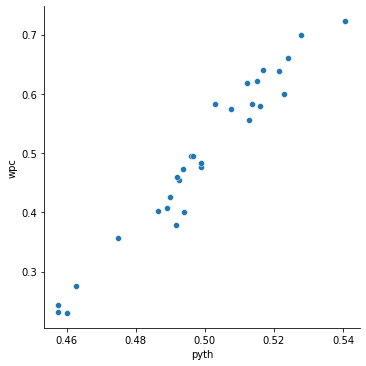

In [96]:
sns.relplot(x='pyth', y='wpc', data=pyth_ex_nba)

# Regression

In [97]:
pyth_lm = smf.ols(formula = 'wpc ~ pyth', data=pyth_ex_nba).fit()
pyth_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wpc   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     599.6
Date:                Sat, 26 Jun 2021   Prob (F-statistic):           1.89e-20
Time:                        20:46:08   Log-Likelihood:                 63.948
No. Observations:                  30   AIC:                            -123.9
Df Residuals:                      28   BIC:                            -121.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.6659      0.129    -20.652      0.000      -2.930      -2.401
pyth           6.3304      0.259     24.486      0.000       5.801       6.860
==============================================================================
Omnibus:                        1.342   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.511   Jarque-Bera (JB):                0.624
Skew:                          -0.340   Prob(JB):                        0.732
Kurtosis:                       3.188   Cond. No.                         59.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpretation

* std err: 0.259 (low)
* t-score: 24.5 (high)
* P-score: 0 << 0.05, so VERY confident this coef is statistically significantly different from 0
    